# 6. Selección de Modelos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset
**nota:** con el objetivo de comprender el uso de las clases `KFold`, `StratifiedKFold`, `DecisionTreeClassifier`, `ParameterGrid`, `GridSearchCV` y `plot_tree` vamos a armar un pequenio dataset de juguete.<br>
<br>
En la segunda parte de esta notebook vamos a utilizar estas mismas clases para analizar otro caso de juguete, pero un poco mas complicado. El caso de los datos no linealmente separables del tipo "XOR" que vimos en la notebook [05 Arboles de Decision.ipynb](https://github.com/nicoambrosis/Introduccion-al-Aprendizaje-Automatico/blob/main/05%20Arboles%20de%20Decision.ipynb). <br>
<br>
Definimos datos de juguete:

In [ ]:
# definimos un conjunto de datos X. Para eso usamos la funcion array() de Numpy
# a la funcion array() tiene que ser alimentada con una lista. 
# dentro de esa lista hay sub elementos que tb son listas. Cada una de esas listas es un vector o una fila de matrix
# la matriz final final tendra tantas vectores o filas como sublistas le pasemos a la funcion np.array()
# La matriz final tendra tantas columnas como elemenos tenga cada una de las sublistas
X = np.array([[2, 2,4], [3, 4, 1], [1, 2, 4], [3, 4, 2], [3, 2, 2], [3, 1, 2], [1, 4, 2], [1, 1, 3]])
X.shape, X

Creamos un dataset almacenado bajo la variable X. Es del tipo array de Numpy (matriz) y consta de 8 observaciones (filas o vectores) y 3 variables para observacion (columnas)

Definimos las etiquetas, es de decir las variables de salida conocidas para cada una de las observaciones que creamos mas arriba.

In [ ]:
y = np.array(("a","a","a","a","a","b","b","b"))
y.shape, y

Si bien no es un paso necesario, la visulizacion de los datos como una DF de pandas siempre ayuda a tener una vision mas general de los datos que tenemos

In [ ]:
df = pd.DataFrame({'Var_1':X[:,0], 'Var_2':X[:,1],'Var_3':X[:,2], 'Labels':y})

print('DataSet de jugete')
display(df)

## Validación Cruzada

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

### K-Fold

Podemos usar [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para hacer cross-validation:

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [ ]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=4, # Number of folds.
          shuffle = True, # Whether to shuffle the data before splitting into batches.
          random_state = 0 # Pass an int for reproducible output across multiple function calls
          )
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f'TRAIN: {train_index} {y_train}\tVAL: {val_index} {y_val}')

Notar que la clase `Kfol` no hace una division ponderando la cantidad de observaciones de cada una de las clases.<br>
Para hacer una division de ese estilo tendriamos que usar la clase `StratifiedKFold`

### División K-Fold Estratificada

Para que la división sea estratificada, es decir que los grupos de entrenamiento mantengan la misma proporcion de etiquetas que los datos originales, usamos `StratifiedKFold`

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits = 3,
                    shuffle = True,
                    random_state = 2
                    )
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f'TRAIN: {train_index}{y_train} \t VAL: {val_index}{y_val}')
    

Los bloques anteriores fueron hechos con fines demostrativos para entender como funciona la estrategia de validacion cruzada y validacion cruzada estratificada. Para el entrenamiento del modelo no vamos a utilizar las clases `KFold` ni `StratifiedKFold`. En cambio vamos a utilizar la clase `GridSearchCV` que nos va a permitir hacer validacion cruzada ademas de otras cosas.

## GridSearchCV

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html). <br>
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes.<br>
Two generic approaches to parameter search are provided in scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations, while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution

### Grilla de Parámetros

In [ ]:
from sklearn.tree import DecisionTreeClassifier

En principio vamos a evaluar 2 de los hiperparametros que podemos ajustar en un modelo del tipo `DecisionTreeClassifier`
vamos a evaluar el `citerion` que setea la funcion que mide la calidad de las divisiones del arbol
y tambien vamos a evaluar `max_depth` que setea la profundidad maxima del arbol.

Tenemos que armar un diccionario en el que cada key es uno de los parametros que queremos evaluar.
El nombre de la key tiene que coincidir exactamente con el nombre que el parametro tiene en la clase que define el modelo
que vamos a evaluar. Los values tienen que ser listas que contengan las diferentes posibilidaddes de los parametros
que queremos evaluar.


Podemos listar todas las combinaciones para usarlas a mano con [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html):

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2],
}

for params in ParameterGrid(param_grid):
    print(params)

Estas son todaslas conbinaciones posibles que existen de los parametros que seteamos con el diccionario `param_grid`

### Grilla de Parámetros + Validación Cruzada

`GridSearchCV` nos sirve para hacer validación cruzada sobre una grilla de parámetros. Sklearn se encarga de todo el proceso y nos devuelve una tabla de resultados y el mejor clasificador obtenido.

La clase `GridSearchCV` toma como argumentos: el modelo que queremos entrenar, un diccionario con los hiperparametros que queremos evaluar (en nuestro caso es param_grid), un parametro para evaluar los diferentes modelos y el numero de subgrupos en que va a dividir los datos de entrenamiento para hacer cross validation.

**Paso a paso que va a hacer la funcion `GridSearchCV`:**<br>

(1) Divide el grupo de entrenamiento en tantos subgrupos como hayamos indicado en el parametro `cv`.<br>
(2) Utiliza la primera configuracion de hiperparametros y entrena un modelo usando un subgrupo de datos de entrenamiento.<br>
(3) Evalua el modelo (usando la estrategia definida en el parametro `scoring`) y guarda el valor.<br>
(4) Repite los pasos (2) y (3) con todos los subgrupos. En cada iteracion guarda el `scoring`.<br>
(5) Reporta el `mean_test_score` y `std_test_score` de esta ronda en la que se evaluo UNA combinacion de hiperparametros.<br>
(6) Cambia los hiperparametros.<br>
(7) Entrena el nuevo modelo con el primer subgrupo de los datos de entrenamiento (igual al paso 2).<br>
(8) Repite los pasos 3,4,5.<br>
(9) Cambia los hiperparametros y repite el proceso.<br>
(10) Repite todo el ciclo hasta que agota todas las posibles combinaciones de hiperparametros.<br>


La búsqueda se puede configurar de varias maneras. Por defecto la validación cruzada es estratificada.

- [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter9)

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1.1 Definimo el modelo de ML con el que vamos a trabajar (A DIFERENCIA DE LOS HACIAMOS ANTES AHORA NO DEFINIMOS PARAMS)
model = DecisionTreeClassifier(random_state=0)

# 1.2. Se define una variable en la que setean los parametros que alimentan a GridSearchCV
cv = GridSearchCV(model,
                  param_grid,
                  scoring = 'accuracy',
                  cv = 3
                 )

# 2. Entrenamos el modelo
cv.fit(X,y)

In [ ]:
# Analizamos los resultados 4 modelos finales (notar que teniendo en cuenta el proceso de cross validation se entrenaron
# 12 modelos en total pero se reporta el promedio y dsviacion estandar de cada combinacion de hiperparametros)

results = cv.cv_results_ # devuelve un diccionario donde cada key es paramtro de los resultados del entrenamiento
                        # de los modelos
for i in results.keys():
    print(i)
    
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

In [ ]:
# imprimimos los resultados en forma ordenada
print("crit.\tdepth\t| mean\tstd\trank")

for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

In [ ]:
# podemos visualizarlo como un DF
df = pd.DataFrame(results)
df.columns


#df = pd.DataFrame(results)
#df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]
#df

In [ ]:
# elegimos las columnas mas significativas para nuestro analisis
df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

Notar que independiente de que funcion usemos para medir la incertidumbre del modelo, los mejores modelos son los que tienen una profundidad de 2

In [ ]:
# pdemos imprimir cual fue el mejor modelo
best_model = cv.best_estimator_
best_model

In [ ]:
cv.best_params_

In [ ]:
# graficamos el modelo
from sklearn.tree import plot_tree
plt.figure(figsize=(15,5))
plot_tree(decision_tree = best_model, filled=True)

plt.title('DecisionTreeClassifier\n', fontsize = 20, fontweight = 'bold')
plt.show()

Podemos inspeccionar las clases:

In [ ]:
best_model.classes_

Podemos realizar una predicción con el mejor modelo encontrado:

In [ ]:
# podemos usar el modelo para predecir la clasificaion de cualquiere observacion que se ajuste a las condicinoes
# de las variables que tenian nustros datos originalmente.
best_model.predict([[1,1,2]])

## Otro dataset sintetico
En este caso vamos a aplicar los conceptos anteriores pero a un dataset de mayor tamano.<br>
Vamos a crear un dataset  de 200 observaciones y 2 features y 2 categorias. <br>
Es el mismo dataset que creamos en la notebook [05 Arboles de Decision.ipynb](https://github.com/nicoambrosis/Introduccion-al-Aprendizaje-Automatico/blob/main/05%20Arboles%20de%20Decision.ipynb) y para el que desarrollamos un algoritmo del tipo `DecisionTreeClassifier`.<br>

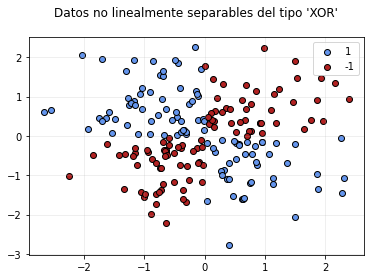

In [21]:
sample_size = 200
features = 2
np.random.seed(0)

# creamos un dataset sintetico
X = np.random.randn(sample_size, features)

# creamos las etiquetas para los datos anteriores
y_true = np.logical_xor(X[:,0] > 0, X[:,1] >0)

y_true = y_true.astype(int) # convierte los datos booleanos en 0 o 1
y_true[y_true == 0] = -1 # convierte las celdas que tienen valor 0 en valor -1.

plt.scatter(X[y_true == 1,0],X[y_true == 1,1], color = 'cornflowerblue', edgecolors='k', label = '1')
plt.scatter(X[y_true == -1,0], X[y_true == -1,1], color = 'firebrick', edgecolors = 'k', label = '-1')
plt.title("Datos no linealmente separables del tipo 'XOR'\n")
plt.grid(alpha = 0.25)

plt.legend()
plt.show()

Al igual que hicimos en la notebook anterior, vamos a usar un modelo de Arboles de decision para predecir la clasificacion de estos datos.

In [9]:
# definimos la grilla de hiperparametros que vamos a querer evaluar para entrenar un modelo DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid

param_grid = {'criterion' : ['gini', 'entropy'],
             'max_depth' : [1,2,3]
             }

for parameters in ParameterGrid(param_grid):
    print(parameters)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'gini', 'max_depth': 3}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 3}


In [11]:
# Entrenemos los 6 modelos posible utilizando la clase GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#1.1 Definimo el modelo de ML con el que vamos a trabajar (A DIFERENCIA DE LOS HACIAMOS ANTES AHORA NO DEFINIMOS PARAMS)
model = DecisionTreeClassifier(random_state = 0)

# 1.2 Se define una variable en la que se setean los parametros que alimentan a GridSearchCV
cv = GridSearchCV(model,
                 param_grid,
                 scoring = 'accuracy',
                 cv = 3
                 )

# 2. Entrenamos los modelos
cv.fit(X, y_true)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3]},
             scoring='accuracy')

Notar que se obtienen 6 modelos entrenados cada uno con una configuracion particular de hiperparametros. Asu vez cada configuracion de hiperparametros fue evaluada mediante cross-validation estratificada 3 veces.<br>


In [13]:
# analizamos los resultados obtenidos
results = cv.cv_results_

params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

# imprimimos los resultados en forma ordenada
print("crit.\tdepth\t| mean\tstd\trank")

for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
gini	1	| 0.51	0.02	5
gini	2	| 0.66	0.16	3
gini	3	| 0.91	0.09	1
entropy	1	| 0.51	0.02	5
entropy	2	| 0.66	0.16	3
entropy	3	| 0.91	0.09	1


Nuevamente vemos que no hay diferencia entre usar Gini o Entropia como criterio de incertidumbre. La mayor diferencia esta en la profundidad del arbol. Tal como habiamos visto en la notebook anterior, necesitamos una profundidad de 3 para poder obtener un modelo con un accuracy aceptable. 

In [14]:
# pdemos imprimir cual fue el mejor modelo
best_model = cv.best_estimator_
best_model

DecisionTreeClassifier(max_depth=3, random_state=0)

In [15]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 3}

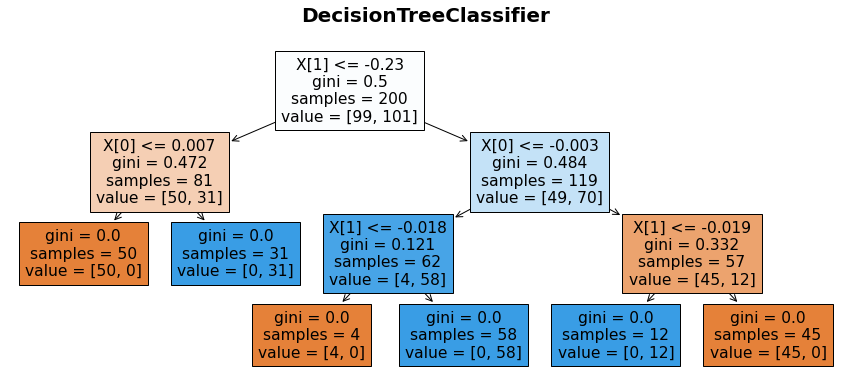

In [18]:
# graficamos el modelo
from sklearn.tree import plot_tree
plt.figure(figsize=(15,6))
plot_tree(decision_tree = best_model, filled=True)

plt.title('DecisionTreeClassifier\n', fontsize = 20, fontweight = 'bold')
plt.show()

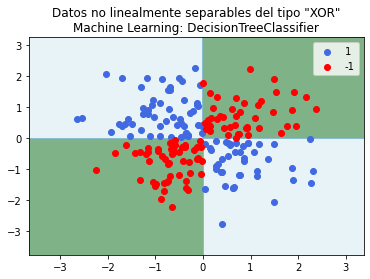

In [19]:
from utils import plot_decision_boundary

plt.figure()
plt.title('Datos no linealmente separables del tipo "XOR"\nMachine Learning: DecisionTreeClassifier')
plot_decision_boundary(lambda x: cv.predict(x), X, y_true)

### Búsqueda Aleatoria

- [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDClassifier??

In [ ]:
model = SGDClassifier(random_state=0)

In [ ]:
from sklearn.utils.fixes import loguniform
from scipy import stats

param_dist = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
        #'preceptron',  # perceptron (not supported)
    ],
    'alpha': loguniform(1e-4, 1e2),  # de 0.0001 a 100.0
}

Al parámetro alpha lo va a obtener desde muestras de una función de probabilidad tipo loguniform:

In [ ]:
from scipy.stats import loguniform

import matplotlib.pyplot as plt
a= 1e-4
b=100
fig, ax = plt.subplots(1, 1)
x = np.linspace(a, b, 100000)
plt.xlim(-1, 5)
plt.ylim(-0.50,4)
ax.plot(x, loguniform.pdf(x, a, b), 'r-', lw=2, alpha=0.6, label='loguniform pdf')

Podemos muestrear mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [ ]:
from sklearn.model_selection import ParameterSampler

for params in ParameterSampler(param_dist, 10, random_state=0):
    print(params)
    model = SGDClassifier(**params, random_state=0)
    #model.fit(...)
    #model.predict(...)

### Búsqueda Aleatoria + Validación Cruzada

También podemos dejar que Sklearn se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, random_state=0)
cv.fit(X, y);

In [ ]:
import pandas as pd
results = cv.cv_results_
df = pd.DataFrame(results)
df[['param_loss', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
cv.best_estimator_

In [ ]:
cv.best_params_

## Referencias


Scikit-learn:

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)